# ARIMA

In [1]:
# data handling
import pandas as pd
import numpy as np

# example data
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

# visualizations
import matplotlib.pyplot as plt

# modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima.model_selection import train_test_split

# import functions from utils
from utils import *

# filter warnings
import warnings
warnings.filterwarnings("ignore")

# set seed to replicate results
seed=123

# Data

Load data from ariline passengers. The series shows a clear upward trend and a seasonal pattern (repetition of the shape of the series every 12 points).

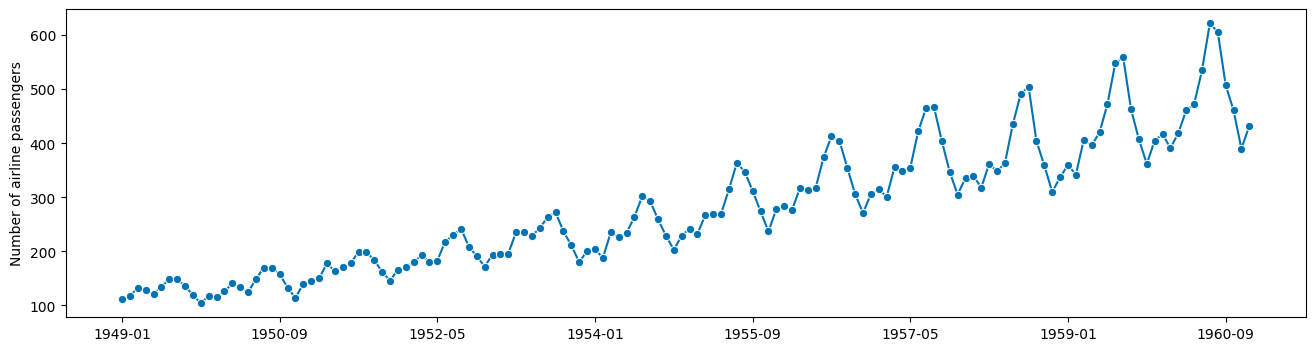

In [2]:
y = load_airline()
plot_series(y)
plt.show()

In [20]:
# split data
from pmdarima.model_selection import train_test_split
train, test = train_test_split(y, test_size=12)

# Check stationarity

Recall that a series with a trend is not stationary, so it is obvious that it will have to be transformed. 
We then look for the order of differentiation necessary to transform it into a stationary series. 

This can be done by checking the autocorrelation and partial autocorrelation plots in addition to the ADF and KPSS tests. However, the pmdarima library allows to estimate the order of differentiation automatically. 

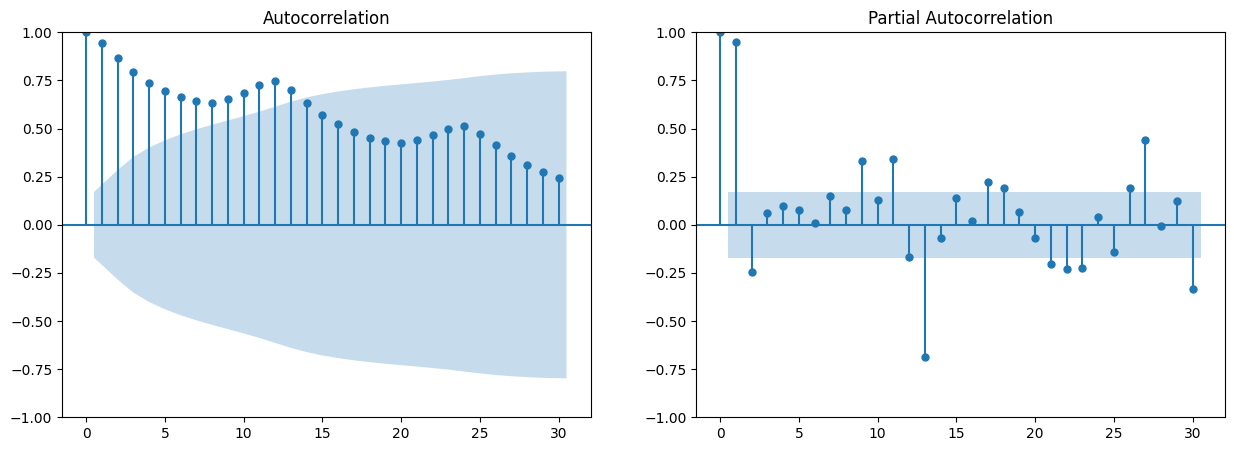

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(train, lags=30, ax=ax[0])
plot_pacf(train, lags=30, ax=ax[1])
plt.show()

In [22]:
# check stationarity with tests
from utils import adf_test, kpss_test
adf_test(train, print_only_result=True)
kpss_test(train, print_only_result=True)


ADF Test Results
-----------------
Result: The timeseries is not stationary

KPSS Test Results
-----------------
Result: The timeseries is not stationary


Automatic way:

In [23]:
from pmdarima.arima.utils import ndiffs

# Estimate the number of differences using an ADF test:
n_adf = ndiffs(train, test='adf')  # -> 0

# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(train, test='kpss')  # -> 0

# Or a PP test:
n_pp = ndiffs(train, test='pp')  # -> 0
# assert n_adf == n_kpss == n_pp == 0

# check results
print('n_adf: ', n_adf)
print('n_kpss: ', n_kpss)

n_adf:  0
n_kpss:  1


At least one differentiation must be applied. Now we are checking the seasonal differencing:

In [24]:
from pmdarima.arima.utils import nsdiffs

# estimate number of seasonal differences using a Canova-Hansen test
D_CH = nsdiffs(train,
            m=12,  # commonly requires knowledge of dataset
            max_D=12,
            test='ch') 

# or use the OCSB test (by default)
D_OCSB = nsdiffs(train,
        m=12,
        max_D=12,
        test='ocsb') 

# print results
print('D_CH: ', D_CH)
print('D_OCSB: ', D_OCSB)

D_CH:  0
D_OCSB:  1


We are applying one differentiation and one seasonal differentiation.

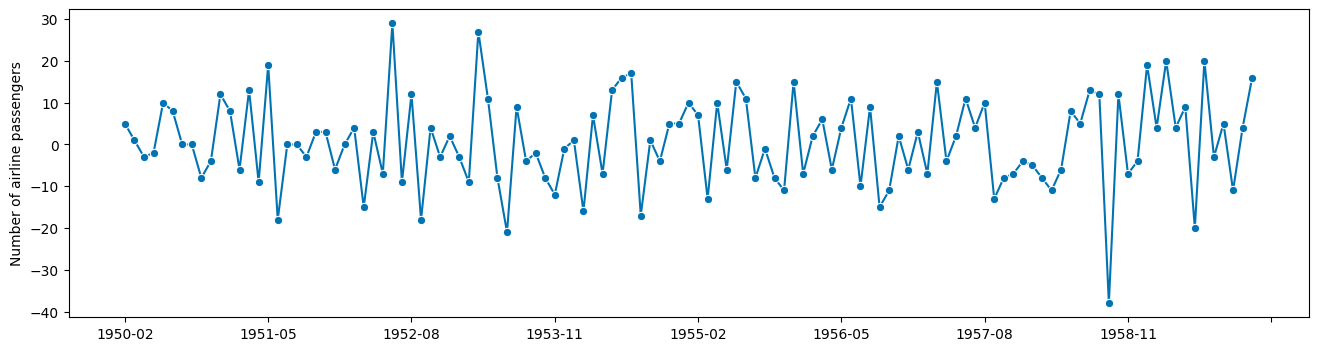

In [25]:
# apply one difference and one seasonal difference
train_diff = train.diff().dropna()
train_diff = train_diff.diff(12).dropna()
# plot
plot_series(train_diff)
plt.show()

Now the series seems stationary. Lets check:

In [26]:
# check stationarity again
for stationarity_test in ['adf', 'kpss', 'pp']:
    print(stationarity_test, ': ', ndiffs(train_diff, test=stationarity_test))

for seasonal_stationarity_test in ['ocsb', 'ch']:
    print(seasonal_stationarity_test, ': ', nsdiffs(train_diff, m=12, max_D=12, test=seasonal_stationarity_test))

adf :  0
kpss :  0
pp :  0
ocsb :  0
ch :  0


The series is stationary!

# Search best order of SARIMA

Now that the order of differentiation has been found, the order of the model parameters is sought. 

In [29]:
import pmdarima as pm
model = pm.auto_arima(train, 
    d=1, 
    D=1, 
    error_action='ignore', 
    seasonal=True, m=12)

model_parameters = model.get_params()
order = model_parameters['order']
seasonal_order = model_parameters['seasonal_order']

print('Best estimated order: \n\t (p, d, q) =', order)
print('Best estimated seasonal order: \n\t (P, D, Q, m) =', seasonal_order)

Best estimated order: 
	 (p, d, q) = (1, 1, 0)
Best estimated seasonal order: 
	 (P, D, Q, m) = (0, 1, 0, 12)


In [30]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -447.951
Date:                            Thu, 13 Oct 2022   AIC                            899.902
Time:                                    22:21:47   BIC                            905.460
Sample:                                         0   HQIC                           902.159
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2431      0.090     -2.697      0.007      -0.420      -0.066
sigma2       108.8757     13.306   

# Forecast

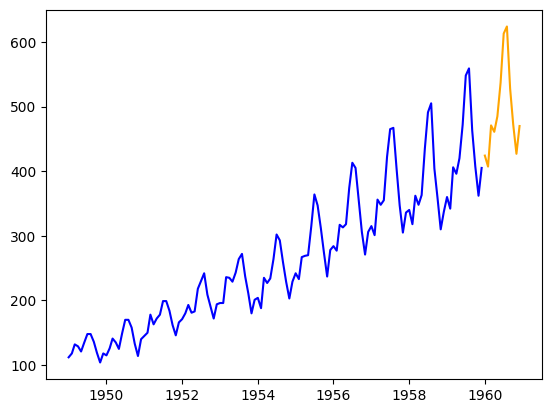

In [36]:
# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

y = y.to_timestamp()

# Visualize the forecasts
x = np.arange(y.shape[0])
plt.plot(y.index[:-12], train, c='blue')
plt.plot(y.index[-12:], forecasts, c='orange')
plt.show()